In [6]:
!pip install lime matplotlib

Epoch 1/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7088 - auc: 0.7909 - loss: 0.5991 - val_accuracy: 0.8978 - val_auc: 0.9590 - val_loss: 0.2672
Epoch 2/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8839 - auc: 0.9405 - loss: 0.2868 - val_accuracy: 0.9120 - val_auc: 0.9671 - val_loss: 0.2150
Epoch 3/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8886 - auc: 0.9510 - loss: 0.2569 - val_accuracy: 0.9127 - val_auc: 0.9690 - val_loss: 0.2077
Epoch 4/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9001 - auc: 0.9560 - loss: 0.2342 - val_accuracy: 0.9170 - val_auc: 0.9699 - val_loss: 0.2047
Epoch 5/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8999 - auc: 0.9644 - loss: 0.2160 - val_accuracy: 0.9170 - val_auc: 0.9718 - val_loss: 0.1953
Epoch 6/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9097 - auc: 0.9622 - loss: 0.2197 - val_accuracy: 0.9134 - val_auc: 0.9707 - val_loss: 0.1989
Epoch 7/25
177/177 ━━━━━━━━━━━━━━━━━━━━

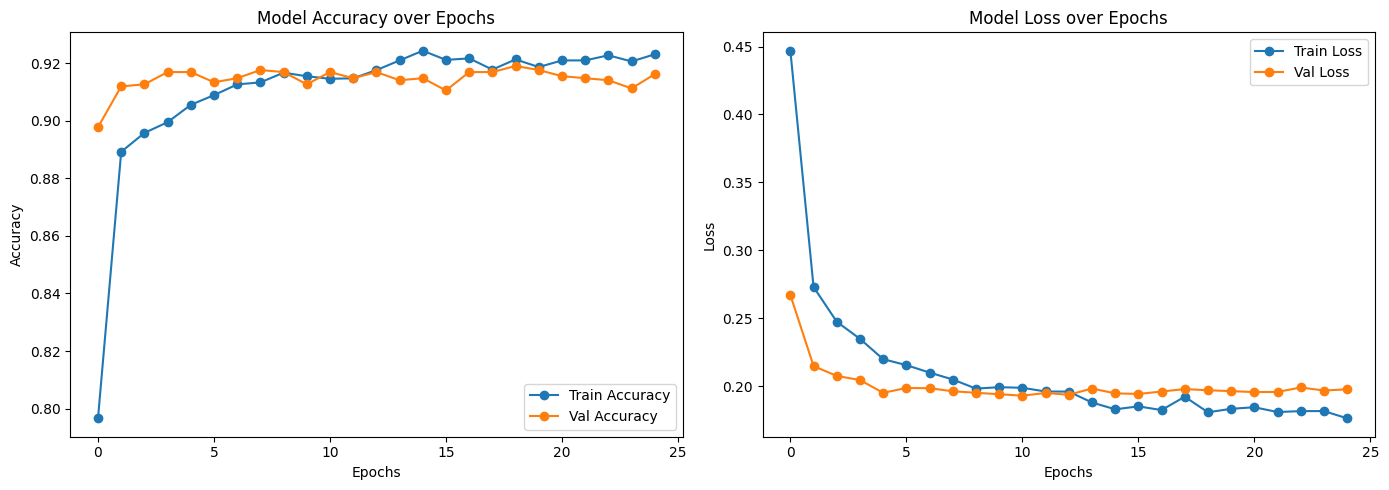

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


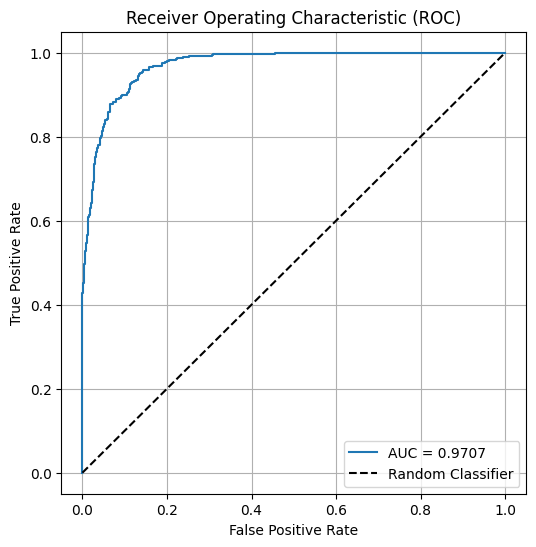

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1009
           1       0.84      0.87      0.86       400

    accuracy                           0.92      1409
   macro avg       0.89      0.90      0.90      1409
weighted avg       0.92      0.92      0.92      1409

Confusion Matrix:
 [[942  67]
 [ 51 349]]


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('Telco_customer_churn.csv')

# Drop irrelevant columns
df = df.drop(columns=['CustomerID', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Churn Reason'])

# Handle missing values in 'Total Charges'
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges'] = df['Total Charges'].fillna(df['Total Charges'].median())

# Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Separate features and target
X = df.drop(columns=['Churn Label', 'Churn Value'])
y = df['Churn Value']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define an enhanced TensorFlow model
def build_custom_model():
    model = models.Sequential([
        layers.InputLayer(shape=(X_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

# Build and train the model
model = build_custom_model()
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy, auc_score = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}, Test AUC: {auc_score:.4f}")

# 1. Accuracy & Loss Curves
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 2. ROC Curve
y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 3. Classification Report & Confusion Matrix
y_pred = (y_probs > 0.5).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


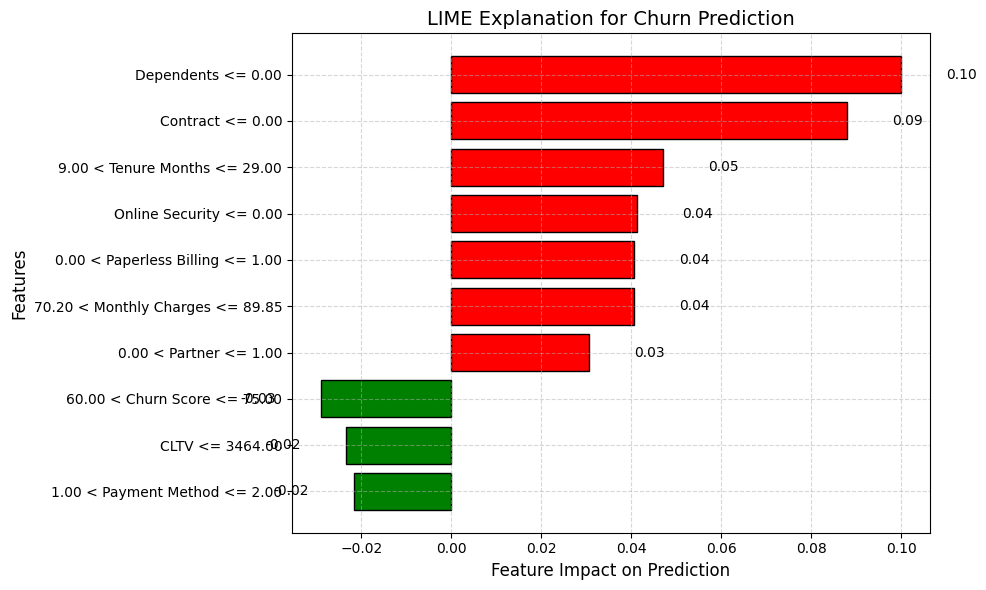

In [11]:
import matplotlib.pyplot as plt

# Get the explanation as a list of (feature, weight) tuples
explanation = exp.as_list()

# Sort features by absolute weight (most impactful first)
explanation = sorted(explanation, key=lambda x: abs(x[1]), reverse=True)

# Separate feature names and their corresponding weights
features = [x[0] for x in explanation]
weights = [x[1] for x in explanation]

# Assign colors: red for features increasing churn, green for reducing
colors = ['red' if w > 0 else 'green' for w in weights]

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(features, weights, color=colors, edgecolor='black')

# Add values at the end of bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01 if width > 0 else width - 0.01,
             bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             va='center',
             ha='left' if width > 0 else 'right',
             fontsize=10)

plt.title('LIME Explanation for Churn Prediction', fontsize=14)
plt.xlabel('Feature Impact on Prediction', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_yaxis()  # Most impactful feature at the top
plt.tight_layout()
plt.show()